Let's begin by computing manually our gradient :

$\frac{d\text{Loss}}{dW} = \frac{d\text{Loss}}{d\hat{y}}\frac{d\hat{y}}{dW}$

With 

$\frac{d\text{Loss}}{d\hat{y}}=\frac{d(\hat{y}-y)^2}{d\hat{y}}=2(\hat{y}-y)$

$\frac{d\hat{y}}{dW} = \Delta t \sigma(Wx-\mu)(1-\sigma(Wx-\mu))$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

C:\Users\Anthony\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [93]:
def dydx(t,x,W, mu, tau, g):
    '''Differential equation'''
    phi = np.tanh
    return (-x + g*(W @ phi(x) - mu))/tau

def rnn(t, IC, dydx, W, tau=1, g=1, mu=0):
    '''Approximate RNN behaviors using RK4 numerical method
    -----------------------
    t : np.linspace()
        Time array
    IC : Line vector
        Initial condition
    dydx : Function
        Differential equation
    W : Matrix of shape (n_neuron x n_neuron)
        Weight matrix
    tau : float
        decay
    g : float
        strengh of RNN
    mu : float/int
        Activation threshold (0 if unspecified)
    ----------------------
    return result and dt
    '''
    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, mu=mu, tau=tau, g=g)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, mu=mu, tau=tau, g=g)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, mu=mu, tau=tau, g=g)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, mu=mu, tau=tau, g=g)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, g=1, tau=1):
    '''
    Generate fake data that follow a RNN function
    -------------------
    n_data : int
        Number of data per neuron
    time : float
        Time of our sample
    IC : Line 
        Initials conditions
    W : Square matrix with shape n_neurons x n_neurons
        Weight Matrix
    ratio : float or int ]0,1]
        Percentage of our fake data that will be use for training
    mu : float or int
        Activation threshold (0 if unspecified)
    -------------------
    Return dict
    '''

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, mu=mu, tau=tau, g=g).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, mu=mu, tau=tau, g=g)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu
    out["tau"] = tau
    out["g"] = g

    return out

In [94]:
def quality(n_neuron, true, train, num_max=1):
    '''
    Plot and identify the quality of the training
    ---------------------
    n_neuron : int
        Number of neurons in our system
    true : ndarray
        True value of our model
    train : ndarray
        Train model
    num_max : int
        Number of neurons with the worst loss function
    '''
    MSE_total = []

    for i in range(n_neuron):
        MSE = np.mean((train[:,i] - true[:,i])**2)
        MSE_total.append(MSE)

    plt.plot(np.linspace(1, n_neuron, n_neuron), MSE_total, "-")
    plt.xlabel("neuron")
    plt.ylabel("loss")
    plt.show()

    worst = []

    for i, neuron in enumerate((sorted(MSE_total)[::-1])):
        if i < num_max:
            worst.append(MSE_total.index(neuron))

    return worst


In [95]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu, g, tau):
        super(RNNModel, self).__init__()
        self.W = W
        self.dt = dt
        self.mu = mu
        self.g = g
        self.tau=tau
    
    def forward(self, x):
        return x * (1-(self.dt/self.tau)) + (torch.matmul(self.W, torch.tanh(x)) + self.mu)*self.dt*self.g/self.tau

In [111]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, tau=1, g=1, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = torch.rand(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    
    model = RNNModel(W=W, dt=dt, mu=mu, tau=tau, g=g)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss = nn.MSELoss()

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred_temp = model(x[:-1].T)
        #All of time step except the last one
        #With N time step, we never use x(t=N) 
        x_pred[1:] = x_pred_temp.T

        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                #with torch.no_grad():
                #    y = x.detach().numpy()
                #    y_pred = x_pred.detach().numpy()
                #    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["tau"] = tau
    out["params"]["g"] = g
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out


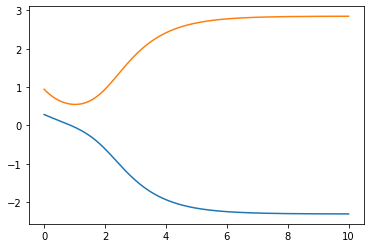

In [100]:
IC = np.random.rand(2)
W_true = np.random.randn(2, 2)

data = GenerateData(n_data=1000, time=20, IC=IC, W=W_true, ratio=1)

t = np.linspace(0, 10, 1000)
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

epoch 0/500 loss 0.001817
epoch 100/500 loss 0.000003
epoch 200/500 loss 0.000001
epoch 300/500 loss 0.000000
epoch 400/500 loss 0.000000


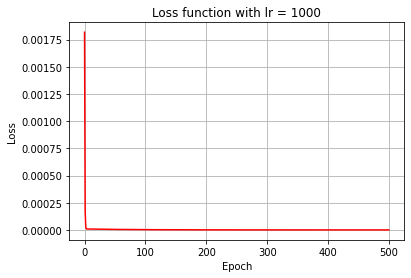

In [101]:
pred = Train_RNN(2, data["Data"].T, data["dt"], mu=data["mu"], n_iters=500, verbose=True, loss_graph=True, lr=1000)

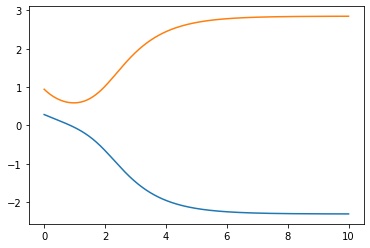

In [102]:
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, train)
plt.show()

-------------------------

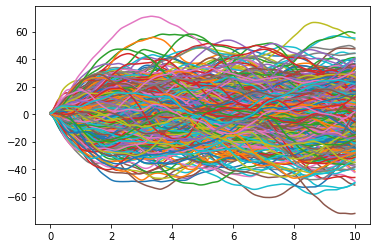

In [129]:
IC = np.random.rand(500)
W_true = np.random.randn(500, 500)

data = GenerateData(n_data=2000, time=20, IC=IC, W=W_true, ratio=1)

t = np.linspace(0, 10, 1000)
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

epoch 0/2500 loss 0.076626
epoch 100/2500 loss 0.000249
epoch 200/2500 loss 0.000115
epoch 300/2500 loss 0.000076
epoch 400/2500 loss 0.000057
epoch 500/2500 loss 0.000046
epoch 600/2500 loss 0.000039
epoch 700/2500 loss 0.000033
epoch 800/2500 loss 0.000029
epoch 900/2500 loss 0.000026
epoch 1000/2500 loss 0.000024
epoch 1100/2500 loss 0.000022
epoch 1200/2500 loss 0.000020
epoch 1300/2500 loss 0.000019
epoch 1400/2500 loss 0.000017
epoch 1500/2500 loss 0.000016
epoch 1600/2500 loss 0.000015
epoch 1700/2500 loss 0.000014
epoch 1800/2500 loss 0.000014
epoch 1900/2500 loss 0.000013
epoch 2000/2500 loss 0.000012
epoch 2100/2500 loss 0.000012
epoch 2200/2500 loss 0.000011
epoch 2300/2500 loss 0.000011
epoch 2400/2500 loss 0.000010


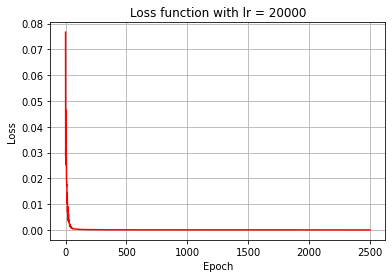

In [130]:
pred = Train_RNN(500, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, verbose=True, loss_graph=True, lr=20000)

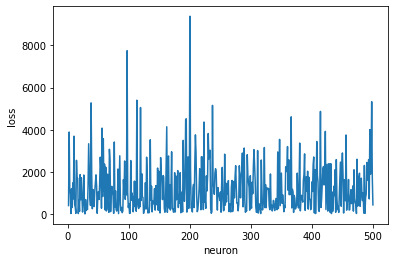

[199, 96, 112]

In [131]:
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(n_neuron=500, true=true, train=train, num_max=3)
qual

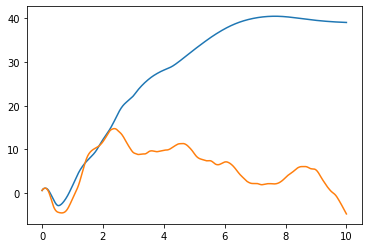

In [132]:
plt.plot(t, train[:,396])
plt.plot(t, true[:,396])

-----------------------

In [133]:
import numpy as np
import pylab
from numpy.linalg import svd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

ts = np.load('1541_F_dff.npy')
ts = ts[:,0:4000]
print(len(ts))
# Smoothing and z-scoring 
sigma = 15
(N,T) = ts.shape
filtered_ts = np.zeros((N,T))
for i in range(N):
    new_ts = zscore(ts[i,:])
    #new_ts = new_ts-np.min(new_ts)
    new_ts = new_ts/np.max(np.abs(new_ts))
    new_ts = gaussian_filter1d(new_ts, sigma)
    filtered_ts[i,:]= new_ts


172


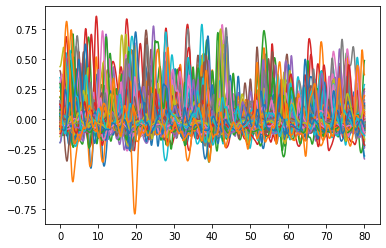

In [134]:
t = np.linspace(0, 80, 4000)
plt.plot(t, filtered_ts.T[:])
plt.show()

epoch 0/2500 loss 0.089119
epoch 100/2500 loss 0.000133
epoch 200/2500 loss 0.000059
epoch 300/2500 loss 0.000036
epoch 400/2500 loss 0.000026
epoch 500/2500 loss 0.000020
epoch 600/2500 loss 0.000016
epoch 700/2500 loss 0.000014
epoch 800/2500 loss 0.000012
epoch 900/2500 loss 0.000011
epoch 1000/2500 loss 0.000009
epoch 1100/2500 loss 0.000009
epoch 1200/2500 loss 0.000008
epoch 1300/2500 loss 0.000007
epoch 1400/2500 loss 0.000007
epoch 1500/2500 loss 0.000006
epoch 1600/2500 loss 0.000006
epoch 1700/2500 loss 0.000006
epoch 1800/2500 loss 0.000005
epoch 1900/2500 loss 0.000005
epoch 2000/2500 loss 0.000005
epoch 2100/2500 loss 0.000005
epoch 2200/2500 loss 0.000004
epoch 2300/2500 loss 0.000004
epoch 2400/2500 loss 0.000004


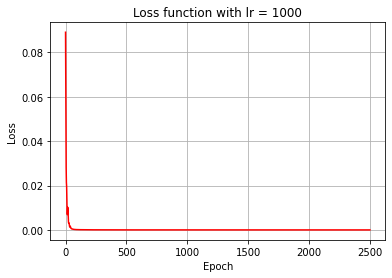

35.31366944313049


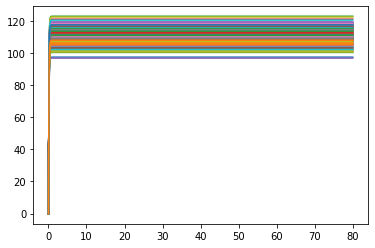

In [143]:
import time
start=time.time()
pred = Train_RNN(172, filtered_ts.T, dt=0.02, mu=0, lr=1000, g=1.3, tau=0.1, n_iters=2500, verbose=True, loss_graph=True)
end = time.time()
print(end-start)
untrain = rnn(t=t, IC=filtered_ts.T[0], dydx=dydx, W=pred["W0"], g=pred["params"]["g"], tau=pred["params"]["tau"])[0]
plt.plot(t, untrain)
plt.show()

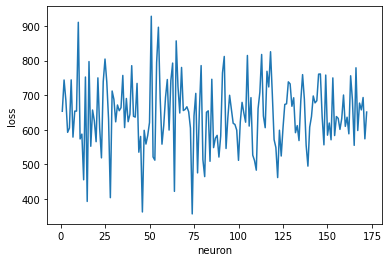

[50, 9, 54]

In [137]:
t = np.linspace(0, 80, 4000)
train = rnn(t, filtered_ts.T[0], dydx=dydx, W=pred["W"])[0]
untrain = rnn(t, filtered_ts.T[0], dydx=dydx, W=pred["W0"])[0]

qual = quality(172, true=filtered_ts.T, train=train, num_max=3)
qual

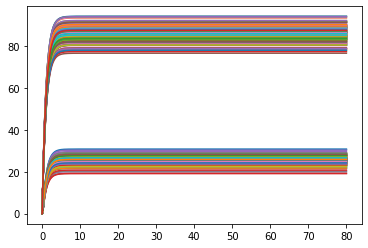

In [139]:
#plt.plot(t, train[:])
#plt.plot(t, filtered_ts.T[:,2])
plt.plot(t, untrain[:])
plt.show()